# Ondelettes et Fourier

## Téléchargement des librairies

In [1]:
import pandas as pd
import numpy as np
import os
import pickle

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp
# FFT
from scipy.fftpack import fft
# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se
#One Class SVM
import sklearn.svm as ssvm

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

## Lecture des données

On lit directement les données nettoyées et dont la longueur a été modifiée à 1024.

In [2]:
import pickle
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    X_1024, ind = mon_depickler.load() #X_1024 : données  #ind : liste des indices des signaux
n = len(X_1024) #nb de signaux
liste_appr = list(np.asarray(X_1024)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(X_1024)[np.asarray(ind) > 299])

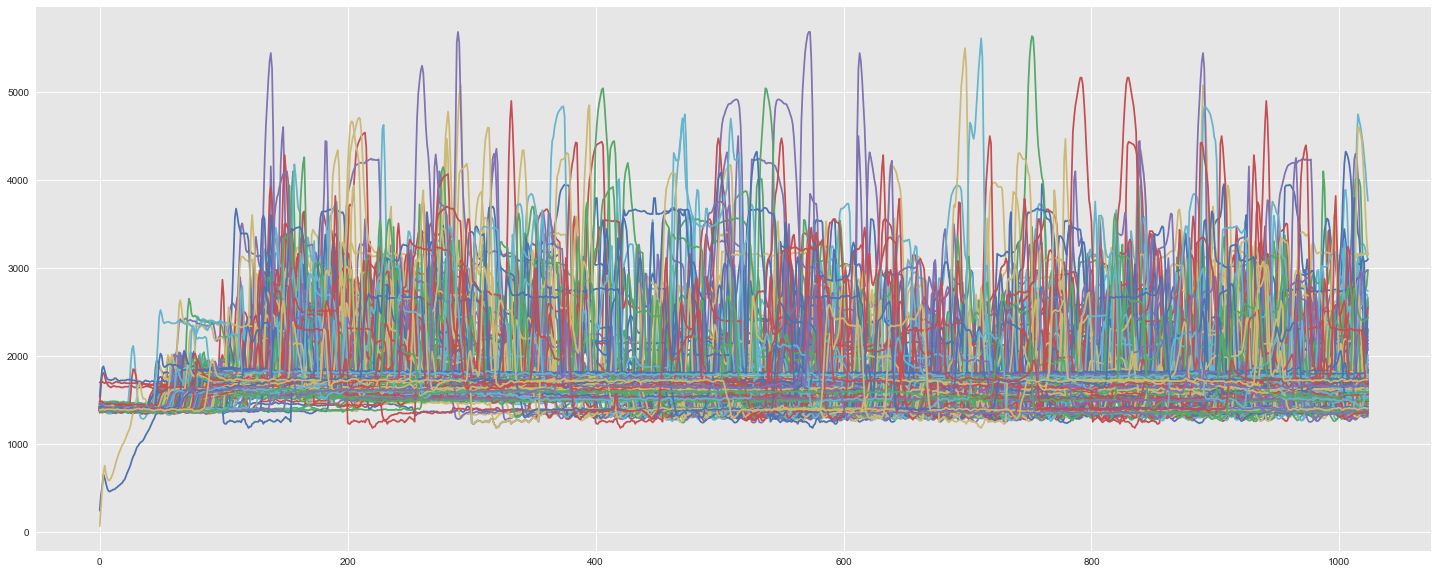

In [3]:
fig = plt.figure(figsize=(25, 10))
for x in X_1024:
    plt.plot(x)

## Coefficients de Fourier

In [4]:
fftCoeff = []
for x in X_1024 :
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre))
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)

fftCoeff = np.array(fftCoeff)
print(fftCoeff.shape)

#Coefficients seuillés
prop_a_garder = 0.1
nb_coeffs = int(fftCoeff.shape[1] * prop_a_garder)
somme = np.sum(fftCoeff**2, axis=0)
fftCoeff_seuil = np.zeros((0, nb_coeffs))
ind_grands = np.argsort(somme)[-nb_coeffs :]
fftCoeff_seuil = fftCoeff[:, ind_grands]

print(fftCoeff_seuil.shape)

(425, 1024)
(425, 102)


## Décomposition en ondelettes

On effectue la décomposition en ondelettes pour chaque signal et on récupère 2 tableaux de coefficients, l'un avec tous les coefficients de chaque signal, l'autre avec les coefficients seuillés. On pourra réaliser la décomposition en ondelettes seuillés avec les modes `hard`, `soft`, `greater` ou `less`.

In [5]:
wavelist=['haar','db2'] 
wf = 'haar' #Choix de l'ondelette

Coeff_ond = []
Coeff_ondT = []
for x in X_1024:
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8) 
    coeffs_flatten = np.hstack(coeffs)
    Coeff_ond.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(1024))
    # Apply Threshold on 4 first levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if j<=3 else c for j,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    Coeff_ondT.append(coeffs_thresh_flatten)
    
Coeff_ond = np.array(Coeff_ond)
Coeff_ondT = np.array(Coeff_ondT)
print(Coeff_ond.shape, Coeff_ondT.shape)
print(np.sum(Coeff_ond!=0), np.sum(Coeff_ondT!=0))

(425, 1024) (425, 1024)
304114 137127


**Q** : QUEL MODE DE SEUILLAGE ?

#### Choix des coefficients

In [6]:
#Coefficient de niveau 7 à 10:
Coeff_ond7=Coeff_ond[:,128:]
#Coefficient de niveau 1 à 6 : 
Coeff_ondA6=Coeff_ond[:,:128]
#Coefficient de niveau 1 à 4 : 
Coeff_ondA4=Coeff_ond[:,:16]

## Liste des différents coefficients sur lesquels appliquer les différentes méthodes

In [7]:
#Liste et dictionnaire des coefficients #Utile pour les fonctions interactives
Coeff_liste=["Tous les coefficients d'ondelettes",
             "Coefficients d'ondelettes, niveau 7",
             "Coefficients d'ondelettes, niveaux 1 à 6",
             "Coefficients d'ondelettes, niveau 1 à 4",
             "Coefficients d'ondelettes seuillés",
             "Coefficients de Fourier",
             "Coefficients de Fourier seuillés",
             "X_1024"]

dict_coeff ={"Tous les coefficients d'ondelettes" : Coeff_ond,
             "Coefficients d'ondelettes, niveau 7" : Coeff_ond7,
             "Coefficients d'ondelettes, niveaux 1 à 6" : Coeff_ondA6,
             "Coefficients d'ondelettes, niveau 1 à 4" : Coeff_ondA4, 
             "Coefficients d'ondelettes seuillés" : Coeff_ondT,
             "Coefficients de Fourier" : fftCoeff,
             "Coefficients de Fourier seuillés" : fftCoeff_seuil,
             "X_1024" : X_1024}

## Analyse en composantes principales sur les coefficients d'ondelettes

#### Fonctions d'affichage

In [8]:
def plot_var_ACP(X_acp, acp) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], ind) :
        ax.plot(x,y,marker=".", color=dict_color[s < len(liste_appr)])
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()
    

#### ACP pour tous les coefficients (A GARDER POUR L'INSTANT)

Ondelettes, tous les coefficients :


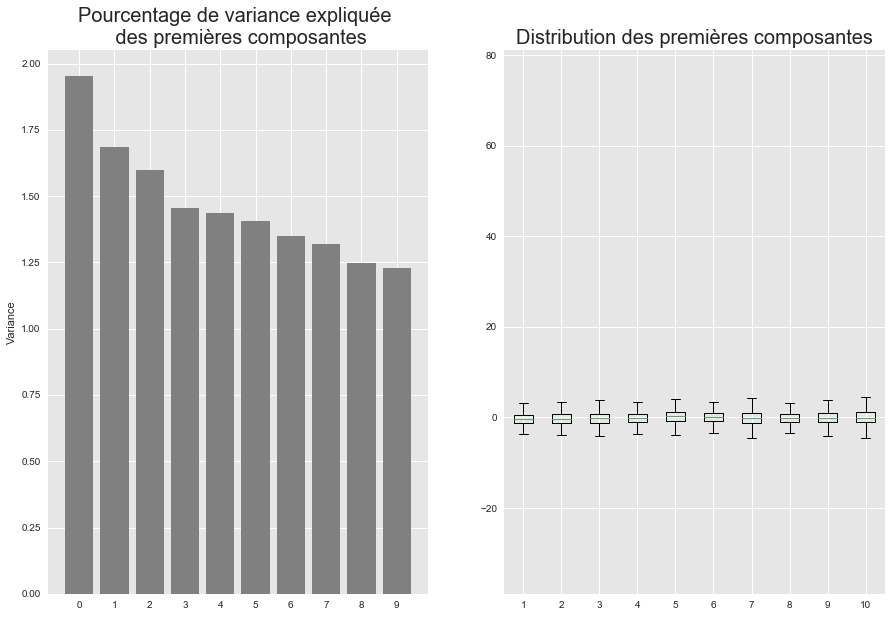

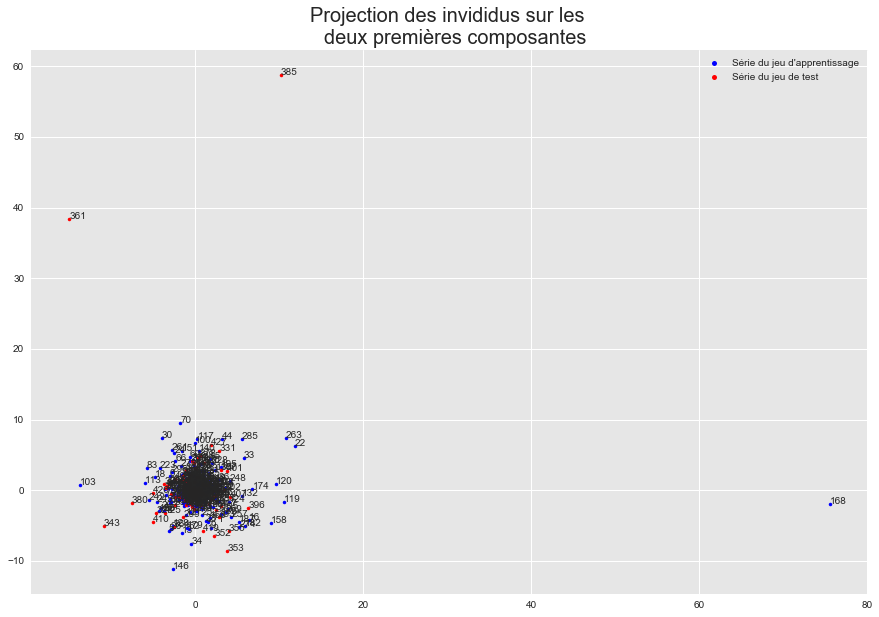

In [9]:
# Tous les coefficients d'ondelettes
acp_ond = sd.PCA()
X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff_ond))
print("Ondelettes, tous les coefficients :")
plot_var_ACP(X_acp_ond, acp_ond)
plot_proj_ACP(X_acp_ond)
plt.show()

#### Visualisation des résultats

In [10]:
@interact(Choix_coeff=Coeff_liste)
def ACP(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    acp = sd.PCA()
    X_acp = acp.fit_transform(sp.scale(Coeff))
    plot_var_ACP(X_acp, acp)
    plot_proj_ACP(X_acp, axe_1=0, axe_2=1)

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coefficients d'ondelettes, niveau 7", "Coefficients d'ondelettes, niveaux 1 à 6", "Coefficients d'ondelettes, niveau 1 à 4", "Coefficients d'ondelettes seuillés", 'Coefficients de Fourier', 'Coefficients de Fourier seuillés', 'X_1024'), value="Tous les coefficients d'ondelettes"), Output()), _dom_classes=('widget-interact',))

## Classification ascendante hierarchique

#### Fonction d'affichage

In [11]:
def plot_dendrogram(Z,p):
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram(Z, p, leaf_rotation=45.,leaf_font_size=15, truncate_mode="level", labels=ind)  # font size for the x axis labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()

#### Dendrogram sur tous les coeff (A GARDER POUR L'INSTANT)

Ondelettes, tous les coefficients :


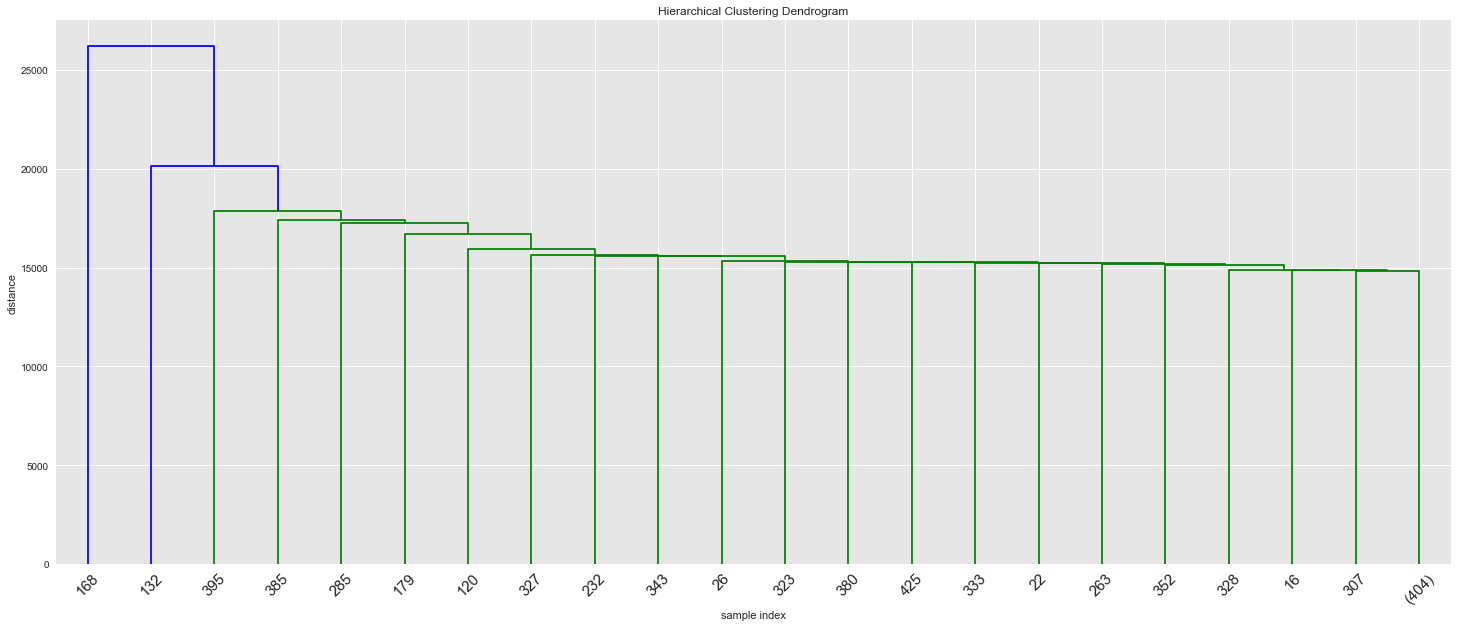

In [12]:
# Tous les coefficients d'ondelettes
Z_ond = sch.linkage(Coeff_ond, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z_ond,5)])
CT_ond = pd.DataFrame(list(C), columns=["HCA_cluster"])
p=20
print("Ondelettes, tous les coefficients :")
plot_dendrogram(Z_ond,p)
plt.show()

#### Visualisation des résultats

In [13]:
@interact(Choix_coeff=Coeff_liste,p=widgets.IntSlider(min=1,max=50,step=1,value=20,continuous_update=False))
def CAH(Choix_coeff,p):
    Coeff=dict_coeff[Choix_coeff]
    Z = sch.linkage(Coeff, 'single')
    C = np.array([c[0] for c in sch.cut_tree(Z,5)])
    CT = pd.DataFrame(list(C), columns=["HCA_cluster"])
    plot_dendrogram(Z,p)
    

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coefficients d'ondelettes, niveau 7", "Coefficients d'ondelettes, niveaux 1 à 6", "Coefficients d'ondelettes, niveau 1 à 4", "Coefficients d'ondelettes seuillés", 'Coefficients de Fourier', 'Coefficients de Fourier seuillés', 'X_1024'), value="Tous les coefficients d'ondelettes"), IntSlider(value=20, continuous_update=False, description='p', max=50, min=1), Output()), _dom_classes=('widget-interact',))

### Fonction d'affichage des anomalies

In [14]:
def print_anomalies(ind_anomalies,ind_data = ind):
    """Permet d'afficher le bon indice de la série dans le cas où des series ont été supprimées du jeu de données"""
    return [ind_data[i] for i in ind_anomalies]

### Fonctions de visualistion des résultats pour IF, OC-SVM, LOF

In [15]:
# A GARDER POUR L'INSTANT
def make_figure(fig, ax, CT, legend=False):
    y_lim = (-1.13,1.13)
    x_lim = [-5,n+5]
    CT_Normal = CT[CT.pred==1]
    CT_Anomaly = CT[CT.pred==-1]
    
    ax.scatter(CT_Normal.index, - CT_Normal.pred, color="green", label="Normal")
    ax.scatter(CT_Anomaly.index, - CT_Anomaly.pred, color="red", label="Anomaly detected")
    
    #for x,y,s in zip(CT_Anomaly.index, - CT_Anomaly.pred, map(str,CT_Anomaly.index)):
    #    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")

    ax.plot(x_lim, [0,0], color="black")
    ax.set_xlim(*x_lim)
    ax.set_ylim(y_lim)
    
    if legend:
        plt.legend(bbox_to_anchor=(1,1), fontsize=20)

**METHODE A ADAPTER**

In [16]:
#Methode : IF, OC-SVM, LOF
#contamination : IF, LOF
#nu : OC-SVM
#n_neighbors : LOF
def level(X_acp_ond,contamination,methode): 
    xx, yy = np.meshgrid(np.linspace(X_acp_ond[:,0].min()-5, X_acp_ond[:,0].max()+5, 500), 
                         np.linspace(X_acp_ond[:,1].min()-1, X_acp_ond[:,1].max()+1, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.set_title(str(methode) + ", contamination = %f" + str(contamination))
    ax.contourf(xx, yy, Z, levels=[Z.min(), clf.threshold_, Z.max()], cmap = plt.cm.PuBu)

    s = 40
    b1 = plt.scatter(X_acp_ond[:,0], X_acp_ond[:,1], c='white', s=s, edgecolors='k')
    labels=[]
    for x,y,ss,  in zip(X_acp_ond[:,0], X_acp_ond[:,1], map(str,ind)):
        ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    plt.legend()

## Isolation Forest

#### IF sur tous les coefficients (A GARDER POUR L'INSTANT)

In [17]:
def IF(Coeff,contamination):
    clf = se.IsolationForest(n_estimators=100, contamination=contamination, bootstrap=True, n_jobs=-1)
    clf.fit(Coeff)
    y_pred = clf.predict(Coeff)
    return pd.DataFrame(list(y_pred), columns=["pred"])

Text(0.5,1,'Ondelettes, tous les coefficients')

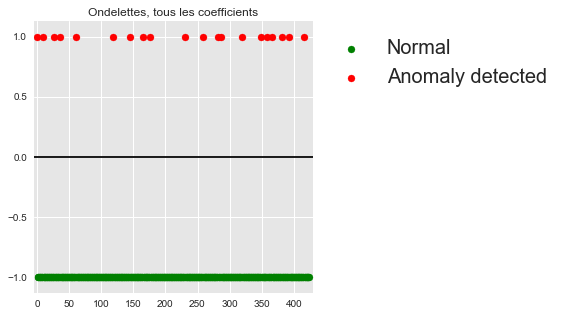

In [18]:
contamination=20/n
#Sur tous les coefficients d'ondelettes
CT_IF_ond = IF(Coeff_ond,contamination)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
make_figure(fig,ax,CT_IF_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients")

#### Visualisation des résultats

In [19]:
contamination=20/n
n_estimators=100

@interact(Choix_coeff=Coeff_liste)
def plot_IF_anomaly(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    
    clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, n_jobs=-1)
    clf.fit(Coeff)
    pred = clf.predict(Coeff)
    
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coefficients d'ondelettes, niveau 7", "Coefficients d'ondelettes, niveaux 1 à 6", "Coefficients d'ondelettes, niveau 1 à 4", "Coefficients d'ondelettes seuillés", 'Coefficients de Fourier', 'Coefficients de Fourier seuillés', 'X_1024'), value="Tous les coefficients d'ondelettes"), Output()), _dom_classes=('widget-interact',))

## One Class SVM

#### OCSVM sur tous les coefficients (A GARDER POUR L'INSTANT)

In [20]:
def OCSVM(Coeff,nu,gamma):
    OCS = ssvm.OneClassSVM(kernel="rbf",nu=nu,gamma=gamma)
    OCS.fit(Coeff)
    pred = OCS.predict(Coeff)
    return pd.DataFrame(list(pred), columns=["pred"])

Text(0.5,1,'Ondelettes, tous les coefficients')

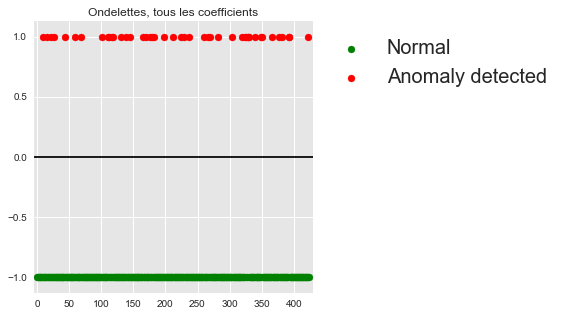

In [21]:
nu=30/len(liste_appr) # Pourcentage estimé d'outliers dans le jeu d'apprentissage
gamma=1e-11
#Sur tous les coefficients d'ondelettes
CT_OCSVM_ond = OCSVM(Coeff_ond,nu,gamma)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
make_figure(fig,ax,CT_OCSVM_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients")

#### Visualisation des résultats

**AFFINER LE CHOIX DE NU + verifier comment ça marche**

In [22]:
kernel="rbf"
#nu=30/len(liste_appr) # Pourcentage estimé d'outliers dans le jeu d'apprentissage
gamma=1e-11

@interact(Choix_coeff=Coeff_liste,nu=widgets.FloatSlider(min=0.01,max=1.0,step=0.01,value=0.05))
def plot_OCSVM_anomaly(Choix_coeff,nu):
    Coeff=dict_coeff[Choix_coeff]
    
    OCS = ssvm.OneClassSVM(kernel=kernel,nu=nu,gamma=gamma)
    OCS.fit(Coeff)
    pred = OCS.predict(Coeff)
    
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coefficients d'ondelettes, niveau 7", "Coefficients d'ondelettes, niveaux 1 à 6", "Coefficients d'ondelettes, niveau 1 à 4", "Coefficients d'ondelettes seuillés", 'Coefficients de Fourier', 'Coefficients de Fourier seuillés', 'X_1024'), value="Tous les coefficients d'ondelettes"), FloatSlider(value=0.05, description='nu', max=1.0, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

## Local Outlier Factor

#### LOF sur tous les coefficients (A GARDER POUR L'INSTANT)

In [23]:
def LOF(Coeff,n_neighbors,contamination,metric):
    clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
    y_pred = clf.fit_predict(Coeff)
    return pd.DataFrame(list(y_pred), columns=["pred"])

Text(0.5,1,'Ondelettes, tous les coefficients')

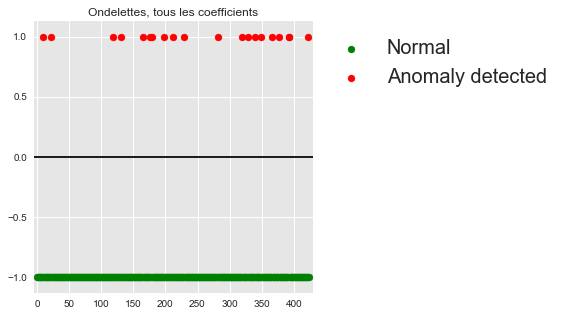

In [24]:
contamination=20/n
metric = "euclidean"
n_neighbors = 15
#Sur tous les coefficients d'ondelettes
CT_LOF_ond = LOF(Coeff_ond,n_neighbors,contamination,metric)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
make_figure(fig,ax,CT_LOF_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients")

#### Visualisation des résultats

In [25]:
contamination=20/n
metric = "euclidean"
#n_neighbors = 15

@interact(Choix_coeff=Coeff_liste,n_neighbors=widgets.IntSlider(min=1,max=30,step=1,value=15))
def plot_LOF_anomaly(Choix_coeff,n_neighbors):
    Coeff=dict_coeff[Choix_coeff]
    
    clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
    pred = list(clf.fit_predict(Coeff))
    
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coefficients d'ondelettes, niveau 7", "Coefficients d'ondelettes, niveaux 1 à 6", "Coefficients d'ondelettes, niveau 1 à 4", "Coefficients d'ondelettes seuillés", 'Coefficients de Fourier', 'Coefficients de Fourier seuillés', 'X_1024'), value="Tous les coefficients d'ondelettes"), IntSlider(value=15, description='n_neighbors', max=30, min=1), Output()), _dom_classes=('widget-interact',))

## Comparaison des méthodes IF, OC-SVM et LOF

In [26]:
methode_liste = ["Isolation Forest", "One-Class SVM", "Local Outlier Factor"]
contamination = 20/n #IF, LOF
n_neighbors = 15 #LOF
nu = 0.05 #OC-SVM
gamma= 1e-11#OC-SVM

#A CONSERVER : peut etre utile pour faire le choix des parametres
def f(**args):
    return args

@interact(Choix_coeff=Coeff_liste, methode=methode_liste)
def plot_anomaly(Choix_coeff, methode):
    Coeff=dict_coeff[Choix_coeff]
    
    if methode=="Local Outlier Factor":
        clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric="euclidean")
        pred = clf.fit_predict(Coeff)
    elif methode=="Isolation Forest":
        clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, n_jobs=-1)
        clf.fit(Coeff)
        pred = clf.predict(Coeff)
    elif methode=="One-Class SVM":
        OCS = ssvm.OneClassSVM(kernel=kernel,nu=nu,gamma=gamma)
        OCS.fit(Coeff)
        pred = OCS.predict(Coeff)
        
        
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coefficients d'ondelettes, niveau 7", "Coefficients d'ondelettes, niveaux 1 à 6", "Coefficients d'ondelettes, niveau 1 à 4", "Coefficients d'ondelettes seuillés", 'Coefficients de Fourier', 'Coefficients de Fourier seuillés', 'X_1024'), value="Tous les coefficients d'ondelettes"), Dropdown(description='methode', options=('Isolation Forest', 'One-Class SVM', 'Local Outlier Factor'), value='Isolation Forest'), Output()), _dom_classes=('widget-interact',))